In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from latent_geometry.model.mnist_vae import (
    load_decoder,
    load_encoder,
)

from latent_geometry.mapping import TorchModelMapping
from latent_geometry.manifold import LatentManifold
from latent_geometry.metric import EuclideanMetric
from latent_geometry.data import load_mnist_dataset
from latent_geometry.utils import project
from path_summary import main
import os

In [3]:
# raise Exception("double check that we wont use already taken gpu ($ nvidia-smi)")
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
model_name, latent_dim = "beta_10", 2

# DEVICE = torch.device("cuda")
# ENCODER = load_encoder(DEVICE, f"{model_name}_encoder.pt", latent_dim=latent_dim)
DECODER = load_decoder(DEVICE, f"{model_name}_decoder.pt", latent_dim=latent_dim)

# z = ENCODER.sample(dataset[0][0].to(DEVICE)[None, :])
# reconstruction = DECODER.decode(z)
# reconstruction.shape

In [5]:
SOLVER_TOL = 0.01
ambient_metric = EuclideanMetric()
latent_mapping = TorchModelMapping(
    DECODER, (-1, 2), (-1, 1, 32, 32), batch_size=10_000, call_fn=DECODER.decode
)
manifold_mnist = LatentManifold(
    latent_mapping, ambient_metric, solver_atol=SOLVER_TOL, bvp_n_mesh_nodes=2_000
)

In [6]:
def show_digits(zss: list[tuple[np.ndarray, ...]], names: list[str] = None):
    fig, axs = plt.subplots(1, len(zss), figsize=(16, 4))
    for i, zs in enumerate(zss):
        xs = []
        for z in zs:
            x = project(latent_mapping)(z).reshape(32, 32)
            xs.append(x)
        img = np.concatenate(xs, axis=0)
        ax = axs[i] if len(zss) > 1 else axs
        ax.imshow(img, vmin=0, vmax=1)
        if names:
            ax.set_title(
                names[i],
                fontsize=8,
            )
        ax.set_axis_off()

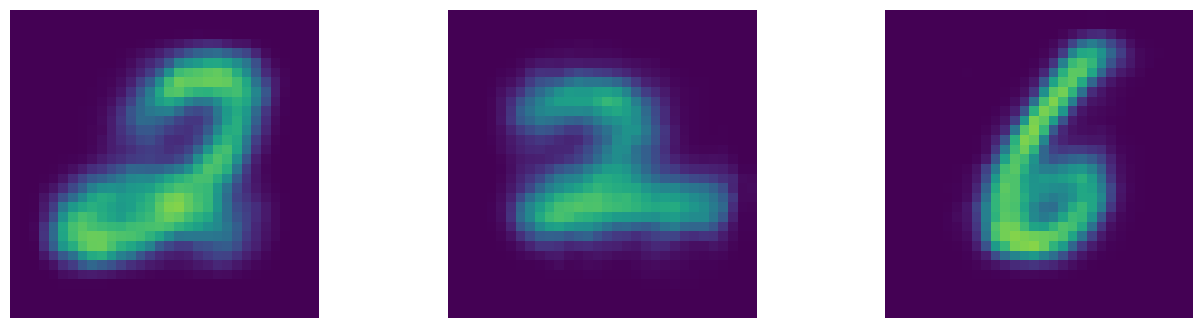

In [15]:
show_digits(
    [(np.array([-0.53, 0.232]),), (np.array([0.21, 1.2]),), (np.array([-1, 0.2]),)]
)

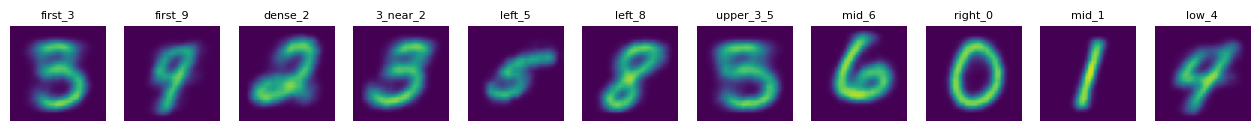

In [7]:
points = {
    "first_3": [0.2, 0.1],
    "first_9": [0.5, -1],
    "dense_2": [-0.54, 0.25],
    "3_near_2": [-0.47, -0.04],
    "left_5": [-1.41, -0.42],
    "left_8": [-0.62, -0.72],
    "upper_3_5": [0.28, 0.37],
    "mid_6": [-0.6, 1.13],
    "right_0": [-1.15, 1.29],
    "mid_1": [-0.87, -1.45],
    "low_4": [0.95, -0.8],
    # "mid_4": [0.95, -0.38],
    # "upper_4": [0.95, 0.68],
}
COOL_POINTS = {k: np.array(v) for k, v in points.items()}
zss, names = zip(*[(tuple(v[None, :]), k) for k, v in COOL_POINTS.items()])
show_digits(zss, names=names)

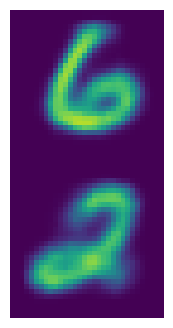

In [8]:
hand_picked_pairs = [
    ("mid_6", "dense_2"),
]
HAND_PICKED_PAIRS = [tuple((COOL_POINTS[x] for x in p)) for p in hand_picked_pairs]
show_digits(HAND_PICKED_PAIRS)

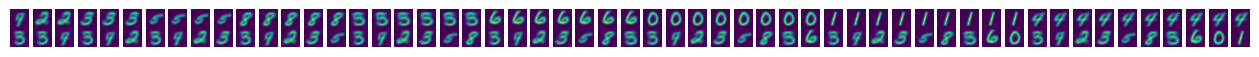

In [10]:
ALL_COOL_PAIRS = []
for i in range(len(zss)):
    for j in range(len(zss)):
        if j >= i:
            continue
        ALL_COOL_PAIRS.append((zss[i][0], zss[j][0]))
show_digits(ALL_COOL_PAIRS)

In [11]:
pairs_lst = [
    ([0.2, 0.1], [0.5, -1]),
    ([1.05, -0.8], [1.35, 0.06]),
    ([-0.4, 0.3], [-0.45, -0.06]),
    ([-1.45, -0.4], [-0.45, -0.06]),
    ([-1, 0], [-0.45, -0.06]),
]
COOL_PAIRS = [tuple(np.array(x, dtype=np.float32) for x in p) for p in pairs_lst]

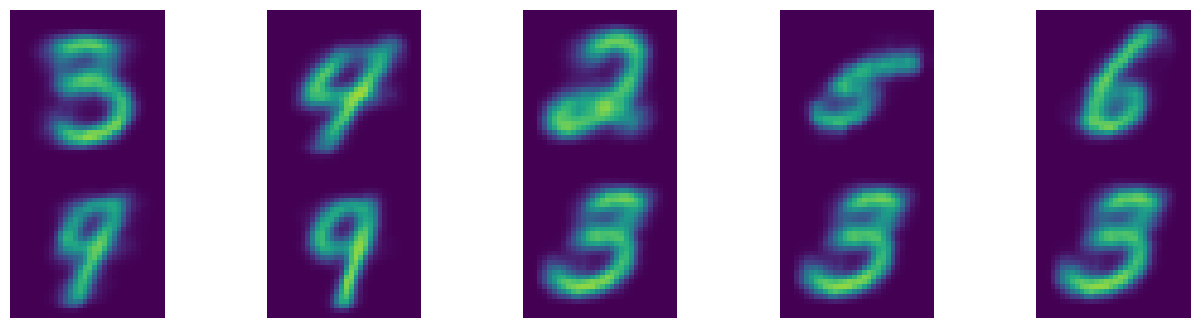

In [12]:
show_digits(COOL_PAIRS)

In [13]:
def sampler_gen_fn(pairs):
    for p in pairs:
        yield p


# sampler_gen = sampler_gen_fn()

# # uglyyy
# def sampler():
#     return next(sampler_gen)

In [14]:
pairs = HAND_PICKED_PAIRS
sampler_gen = sampler_gen_fn(pairs)


def sampler():
    return next(sampler_gen)


# main(
#     "beta_10",
#     2,
#     len(pairs),
#     "final",
#     sampler,
#     solver_tols=(0.01, 0.05, 0.1, 0.5, 1.0),
# )

In [15]:
HAND_PICKED_PAIRS[0]

(array([-0.6 ,  1.13]), array([-0.54,  0.25]))

# ugly

In [16]:
decoder = load_decoder("cuda", f"{model_name}_decoder.pt", latent_dim=latent_dim)

ambient_metric = EuclideanMetric()
latent_mapping = TorchModelMapping(
    decoder,
    (-1, latent_dim),
    (-1, 1, 32, 32),
    batch_size=5_000,
    call_fn=decoder.decode,
)
manifold_mnist = LatentManifold(
    latent_mapping,
    ambient_metric,
    bvp_n_mesh_nodes=20_000,
    solver_atol=10,
    pullback_metric_eps=1e-3,
)

In [17]:
from path_summary import (
    create_straight_path,
    summarize_path,
    create_path_in_ambient_fig,
    get_img_from_fig,
    create_summary_fig,
    allign_arrays,
)

In [19]:
# geodesic_path = manifold_mnist.shortest_path(*HAND_PICKED_PAIRS[0])
# straight_path = create_straight_path(
#     geodesic_path(0), geodesic_path(1), manifold_mnist.metric # BAAAAD
# )
straight_path = create_straight_path(
    *HAND_PICKED_PAIRS[0], manifold_mnist.metric  # BAAAAD
)
paths = [
    (straight_path, "straight path"),
    # (geodesic_path, "geodesic"),
]

In [20]:
img_arrs = []
dfs = []
for prefix, (path, name) in zip(["e)", "d)"], paths):
    df = summarize_path(path, n_points=100)
    df["path"] = name
    dfs.append(df)
    fig = create_path_in_ambient_fig(
        path, n_points=7, title=f"{prefix} observation interval points on the {name}"
    )
    img_arrs.append(get_img_from_fig(fig))
    plt.close(fig)

df = pd.concat(dfs).reset_index(drop=True)
summ_fig = create_summary_fig(df)
img_arrs.append(get_img_from_fig(summ_fig))
plt.close(summ_fig)
img = allign_arrays(img_arrs[::-1])

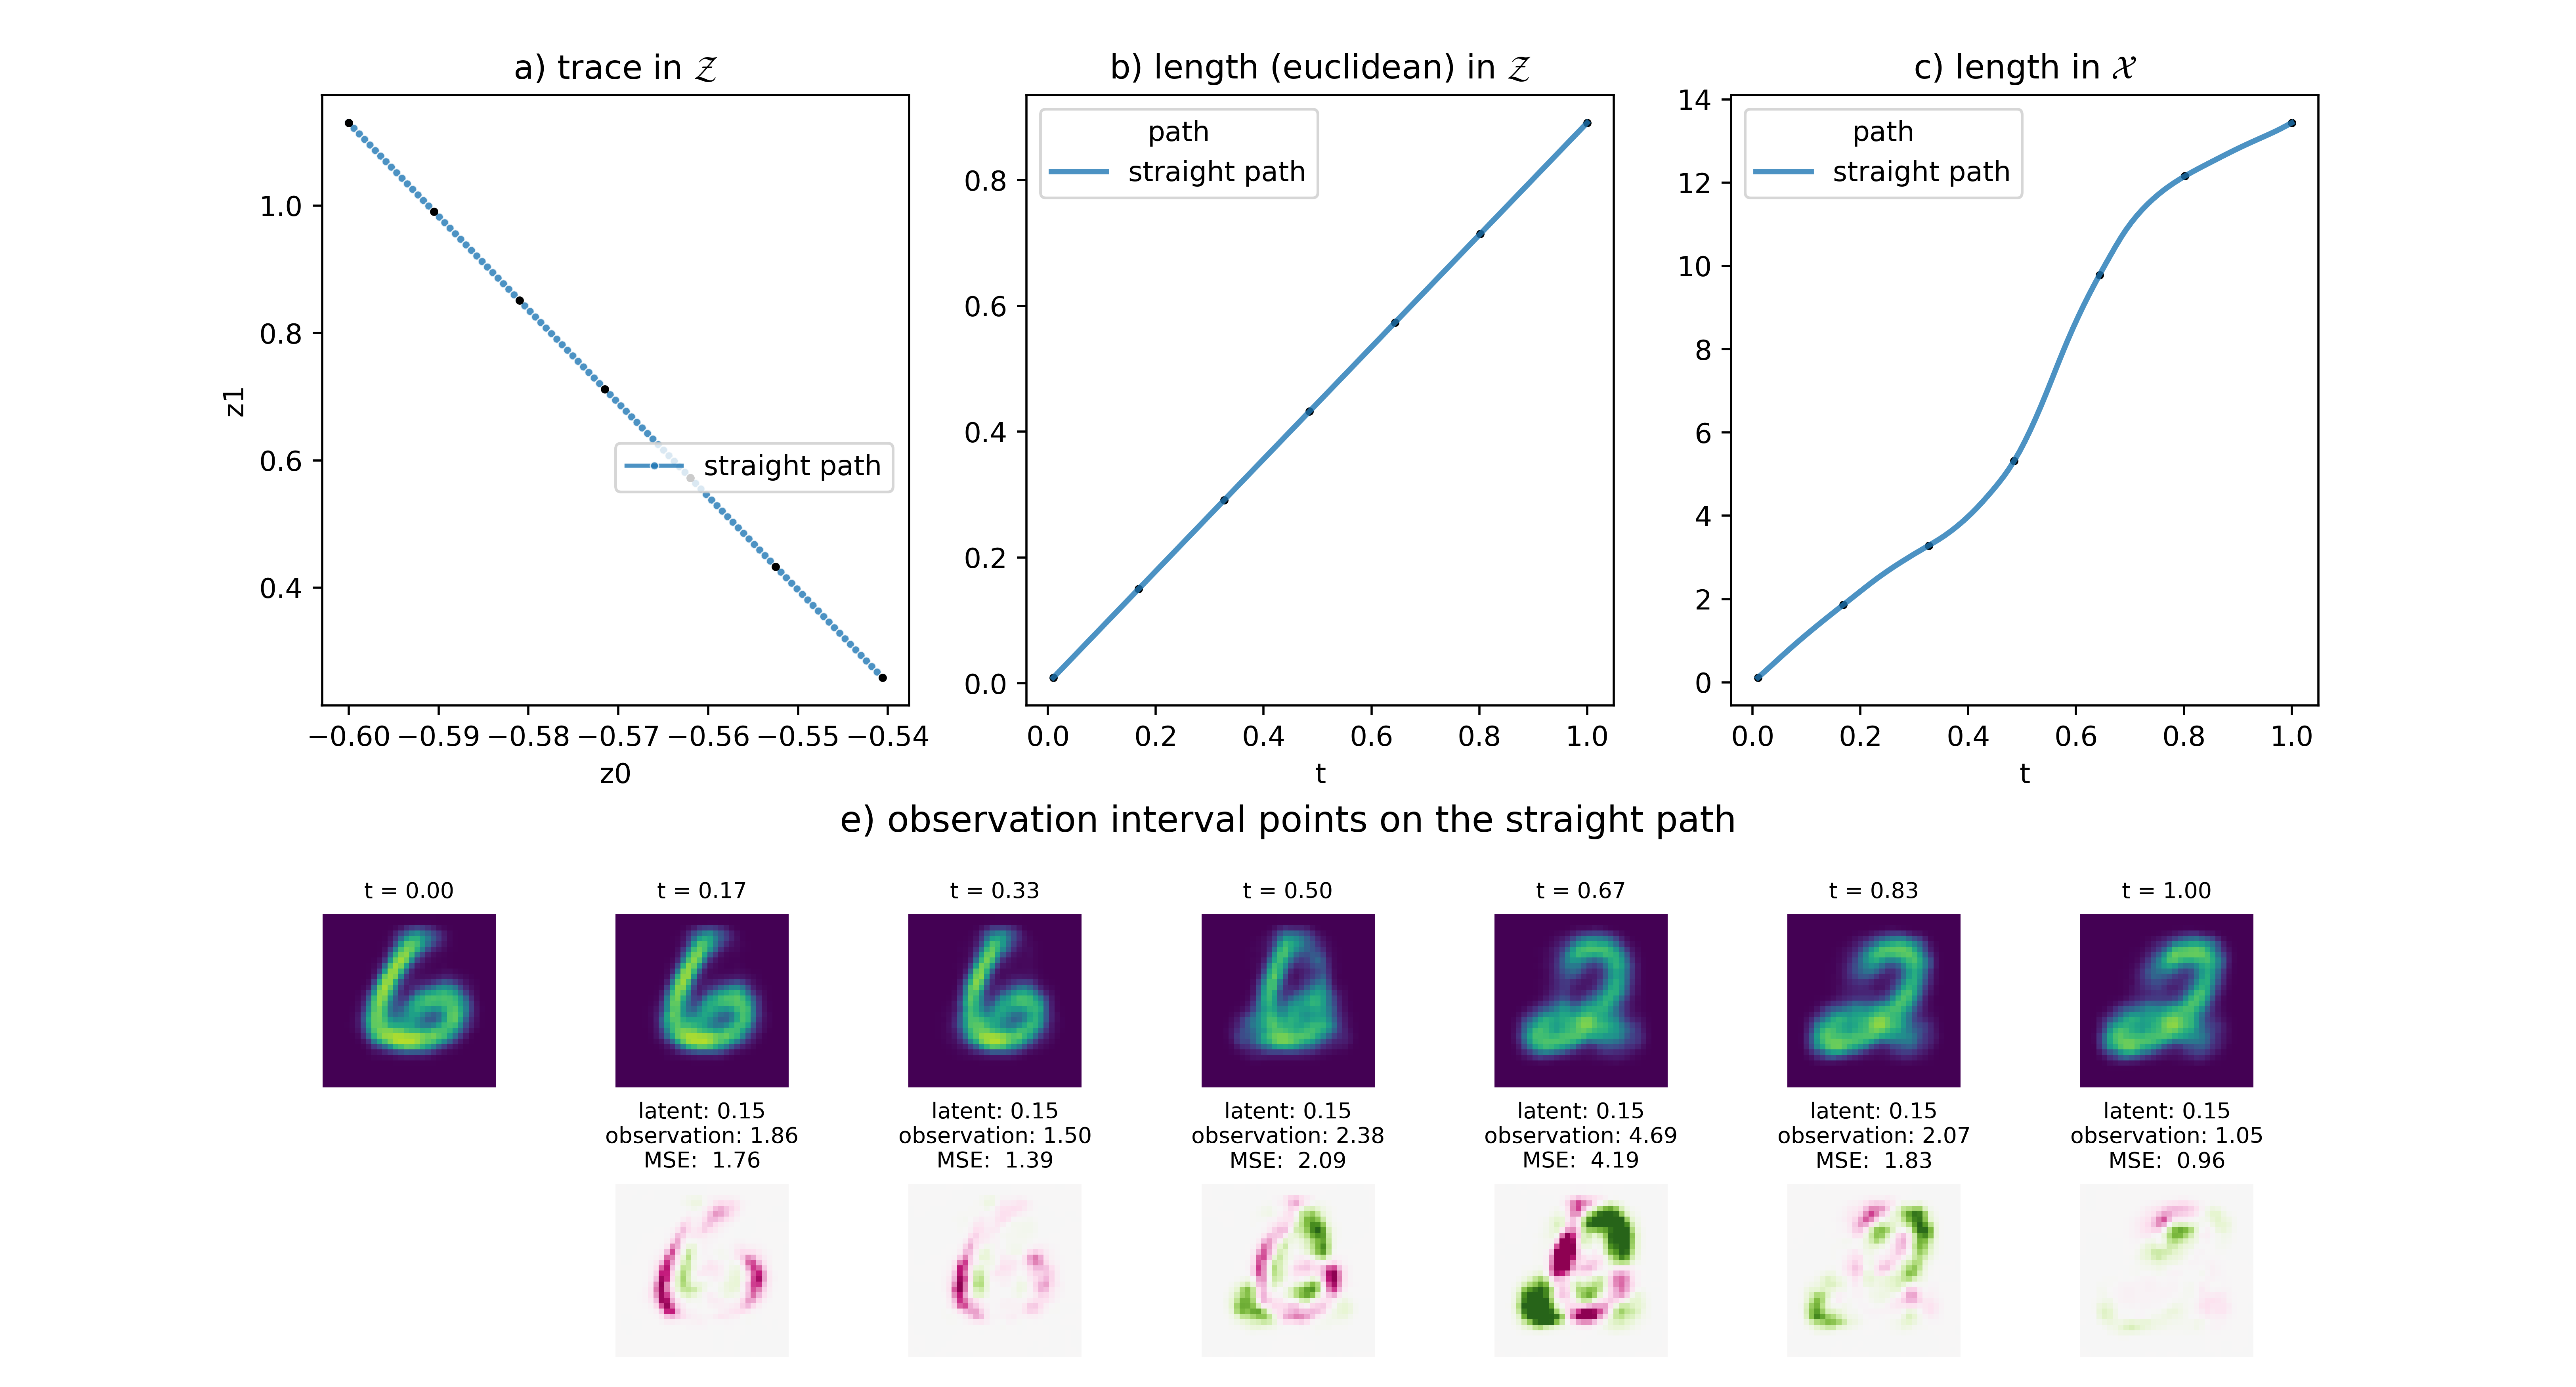

In [21]:
img

In [23]:
from latent_geometry.config import FIGURES_DIR

In [24]:
# img.save(FIGURES_DIR / "mnist" / "images" / "mgr" / "path_in_latent_2d_only_straight.png")